In [1]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from direvo_functions import *
import selection_function_library as slct
from ruggedness_functions import *
import os
import tqdm
import pandas as pd
import itertools
from matplotlib import rcParams

### Notes on plot formatting

- Height 3
- DPI = 300
- Axes labels = 8, axes tick labels = 6
- Title = 10
- Heatmap: viridis, defined colours: see below

In [2]:
## Plot colours

c2 = 'tab:blue'#298c8c'
c1 = 'tab:orange' #800074'
c3 = '#f55f74'
c4 = 'tab:green'

In [3]:
## Fontsizes

titlesize = 10
labelsize = 8
ticksize = 6
legendsize = 8
dpi = 350
plt.rcParams["font.family"] = "DejaVu Sans"

# Section 1 - Inferring ruggedness on NK

### Example fitness decay curves

In [4]:
with open('plot_data/smooth_rugged_example.pkl', 'rb') as f:
    smooth_rugged, fitted_lines = pickle.load(f)

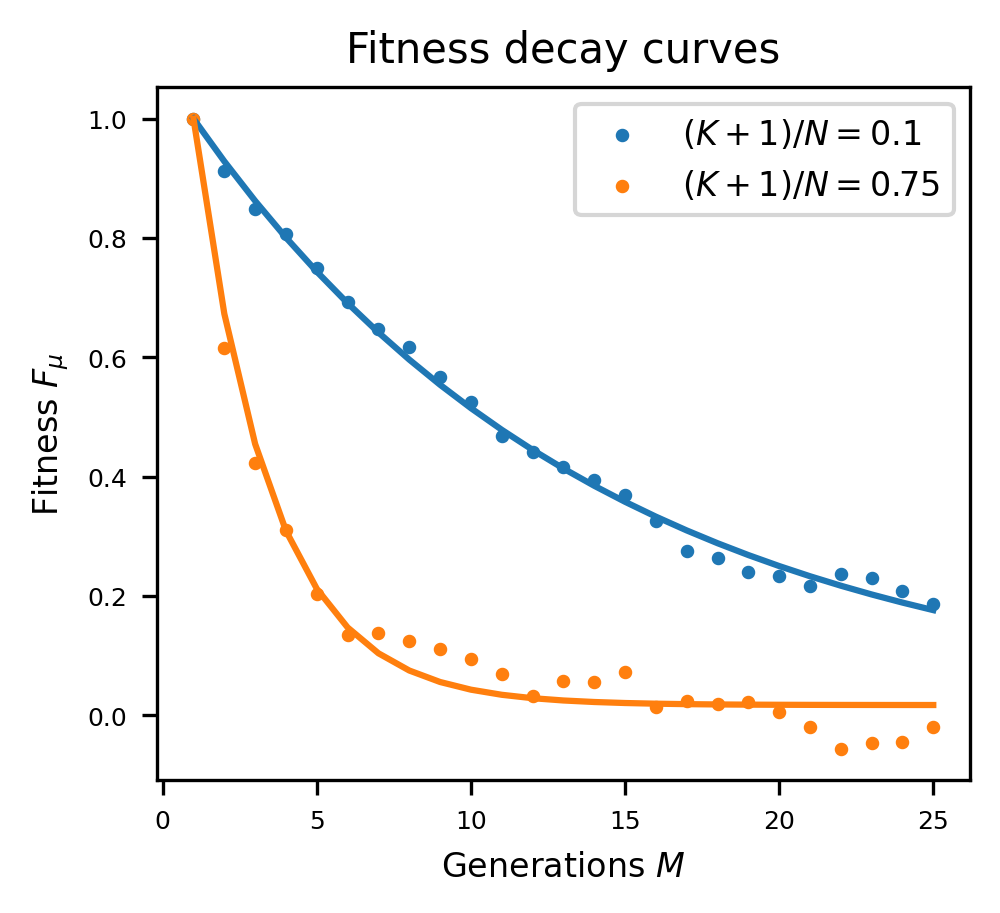

In [5]:
plt.figure(figsize=(3.5,3), dpi=300)

generations = np.linspace(1,25,25)

#plt.plot(generations, smooth_rugged[1], label = r"$K/N = 0.1$", c=c2)
plt.scatter(generations, smooth_rugged[1], label = r"$(K+1)/N = 0.1$", c=c2,s=5)
plt.plot(generations, fitted_lines[1], c=c2)
plt.scatter(generations, smooth_rugged[0], label = r"$(K+1)/N = 0.75$", c=c1,s=5)
plt.plot(generations, fitted_lines[0], c=c1)
plt.legend(fontsize = legendsize)

plt.title('Fitness decay curves', fontsize = titlesize)
plt.xlabel('Generations $M$', fontsize=labelsize)
plt.ylabel(r'Fitness $F_\mu$', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.savefig('figures/decay_curves_example.pdf', dpi=dpi)

### Ruggedness prediction accuracy over NK

In [6]:
with open('plot_data/ruggedness_accuracy.pkl', 'rb') as f:
    k_plus_one_over_ns, decay_rates = pickle.load(f)

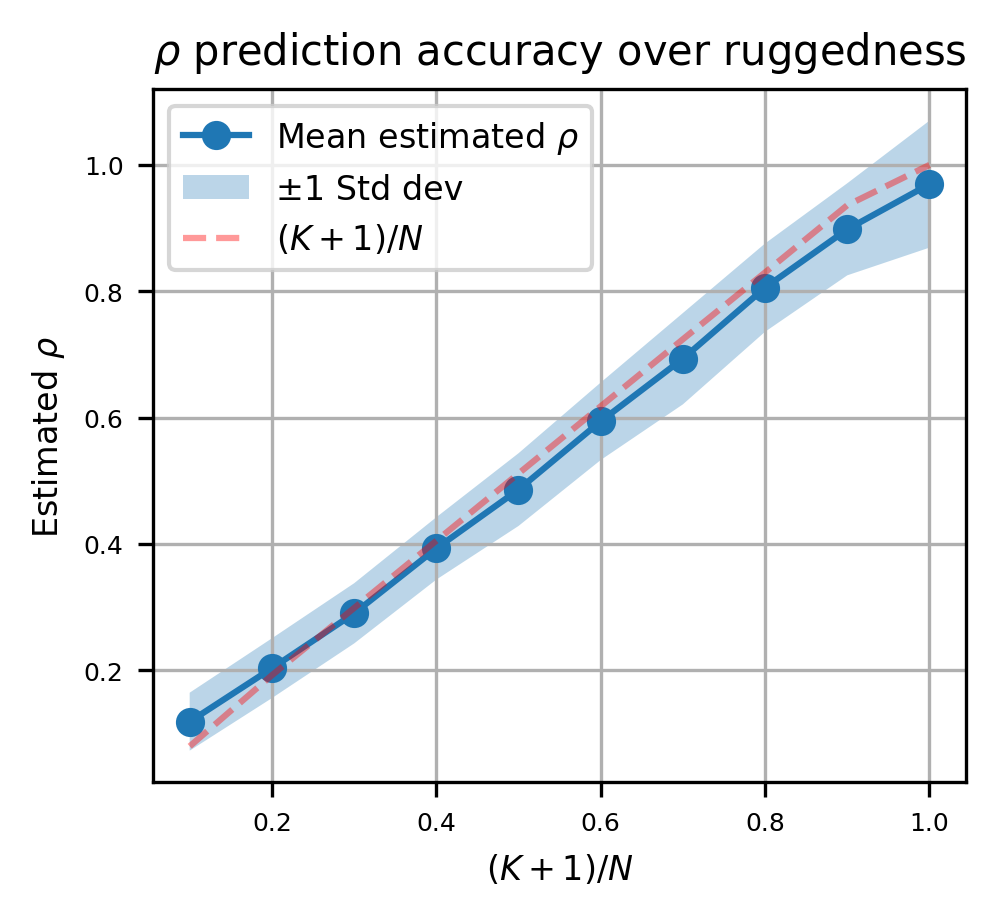

In [7]:
# Step 1: Get ordering for rho
arg_sort_kn = np.argsort(k_plus_one_over_ns)
sorted_rho = k_plus_one_over_ns[arg_sort_kn]
sorted_decay = decay_rates[arg_sort_kn]

# Step 2: Group the values
grouped_rho = sorted_rho.reshape(10,-1)
grouped_decay = sorted_decay.reshape(10,-1)

mean_rho = np.mean(grouped_rho, axis = 1)
mean_decay = np.mean(grouped_decay, axis = 1)
std_decay = np.std(grouped_decay, axis = 1)

true_k_over_n = np.linspace(0.1,1,10)

# Step 3: Create Fill-Between Plot
plt.figure(figsize=(3.5,3), dpi=300)
plt.plot(true_k_over_n, mean_decay, 'o-', label=r"Mean estimated $\rho$")  # Line plot with markers
plt.fill_between(true_k_over_n, mean_decay - std_decay, mean_decay + std_decay, alpha=0.3, label="±1 Std dev")  # Shaded error band

plt.plot(true_k_over_n, mean_rho, c='red', alpha=0.4,linestyle='--', label=r'$(K+1)/N$')

# Labels and Title
plt.xlabel(r"$(K+1)/N$", fontsize=labelsize)
plt.ylabel(r"Estimated $\rho$", fontsize=labelsize)
plt.title(r"$\rho$ prediction accuracy over ruggedness", fontsize = titlesize)
plt.legend(fontsize=legendsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.grid(True)

# Show plot
plt.savefig('figures/accuracy_over_K.pdf', dpi=dpi)


### Ruggedness prediction accuracy over population size

In [8]:
with open('plot_data/popsize_accuracy.pkl', 'rb') as f:
    popsize_decay_rates, pops = pickle.load(f)

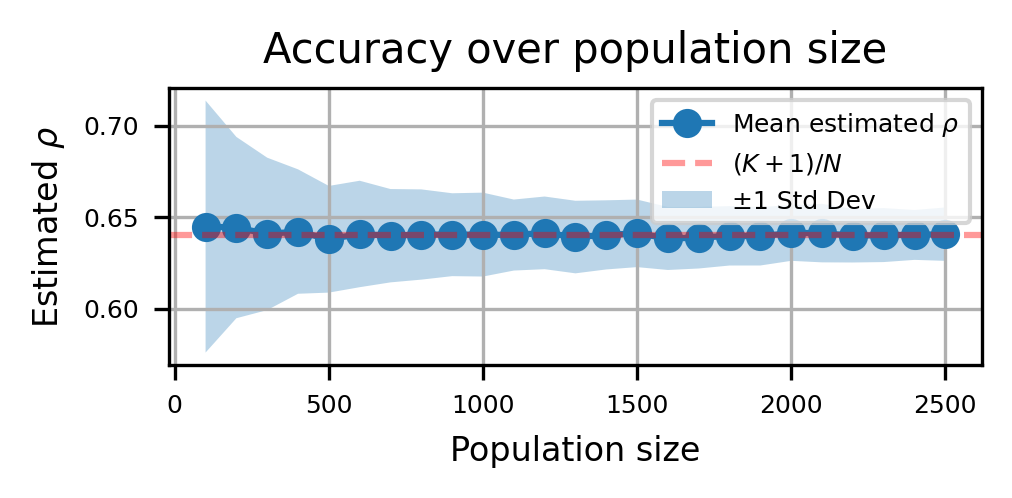

In [9]:
y_means = popsize_decay_rates.mean(axis=1)
y_stds = popsize_decay_rates.std(axis=1)
pop_y_means = y_means
conv_p = 16/25
# Step 3: Create Fill-Between Plot
plt.figure(figsize=(3.5,1.2), dpi=300)
plt.plot(pops, y_means, 'o-', label=r"Mean estimated $\rho$")  # Line plot with markers
plt.axhline(y=conv_p, label=r'$(K+1)/N$', c='red', alpha=0.4, linestyle='--')
# plt.plot(pops, np.ones_like(pops) * 12/25, ls = '--', label="True") 
plt.fill_between(pops, y_means - y_stds, y_means + y_stds, alpha=0.3, label="±1 Std Dev")  # Shaded error band
plt.grid(True)
plt.legend(fontsize = legendsize-2, loc="upper right")
plt.tick_params(axis='both', which='major', labelsize=ticksize)

plt.title('Accuracy over population size', fontsize = titlesize)
plt.ylabel(r"Estimated $\rho$", fontsize=labelsize)
plt.xlabel('Population size', fontsize=labelsize)
plt.savefig('figures/accuracy_over_popsize.pdf', dpi=dpi)

### Ruggedness prediction accuracy over mutation rate

In [10]:
with open('plot_data/mut_accuracy.pkl', 'rb') as f:
    mut_decay_rates, muts = pickle.load(f)

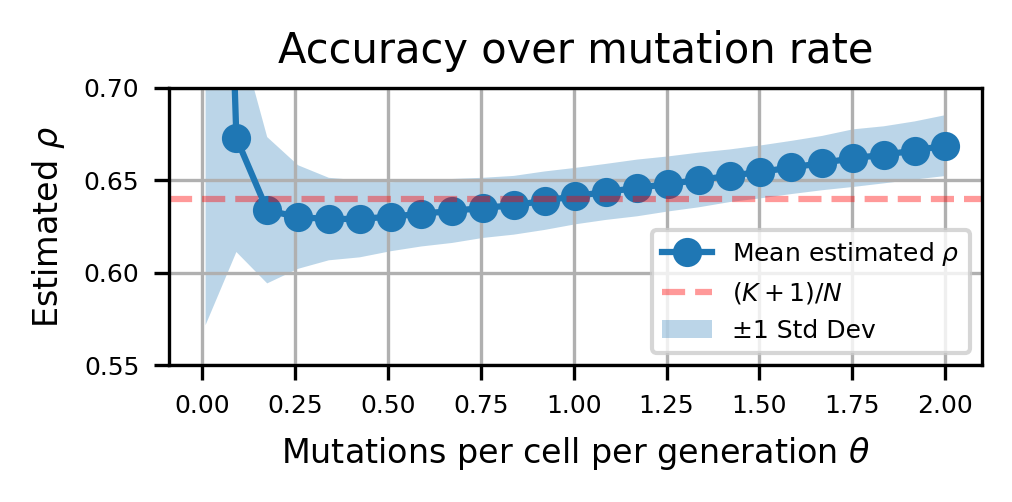

In [11]:

y_means = np.mean(mut_decay_rates,axis=1)
y_stds = mut_decay_rates.std(axis=1)

# Step 3: Create Fill-Between Plot
plt.figure(figsize=(3.5,1.2), dpi=300)
plt.plot(muts, y_means, 'o-', label=r"Mean estimated $\rho$")  # Line plot with markers
plt.axhline(y=conv_p, label=r'$(K+1)/N$', c='red', alpha=0.4,linestyle='--')
plt.fill_between(muts, y_means - y_stds, y_means + y_stds, alpha=0.3, label="±1 Std Dev")  # Shaded error band
# plt.plot(muts, np.ones_like(muts) * 12/25, ls = '--', label="True") 
plt.grid(True)
plt.legend(fontsize = legendsize-2, loc='lower right')
plt.tick_params(axis='both', which='major', labelsize=ticksize)
# plt.ylim(0.0,1.0)
# plt.xlim(0,1.0)
plt.xlabel(r'Mutations per cell per generation $\theta$', fontsize=labelsize)
plt.ylabel(r"Estimated $\rho$", fontsize=labelsize)
plt.ylim(0.55,0.7)
plt.title('Accuracy over mutation rate', fontsize=titlesize)
plt.savefig('figures/accuracy_over_mut.pdf', dpi=dpi)


### Comparison of ruggedness metrics on NK

In [12]:
with open('plot_data/NK_ruggedness_metric_comparison.pkl', 'rb') as f:
    NK_roughness_to_slope, NK_fourier, convergence_rates, NK_paths_to_max, NK_closest_max, k_over_ns, NK_le_normed = pickle.load(f)

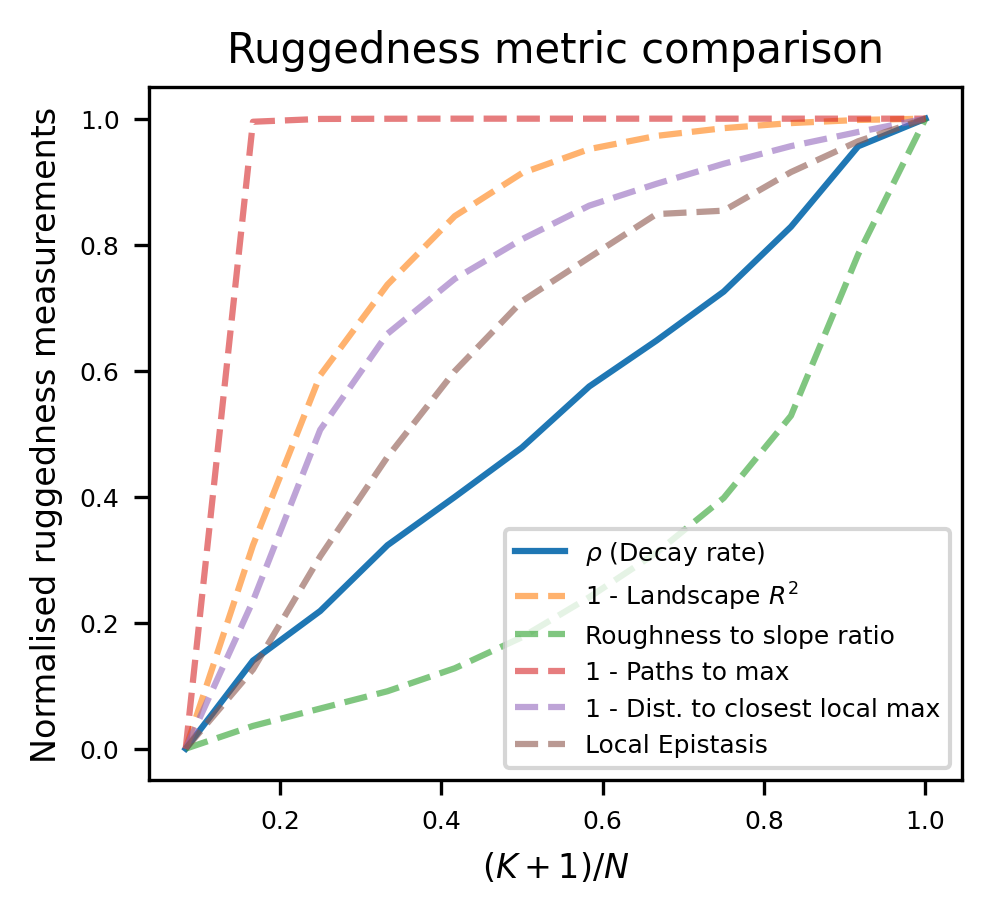

In [13]:
plt.figure(figsize=(3.5,3), dpi=300)
plt.plot(k_over_ns, convergence_rates/convergence_rates.max(), label = r'$\rho$ (Decay rate)')
plt.plot(k_over_ns, 1 - NK_fourier/NK_fourier.max(), label = r'1 - Landscape ${R}^{2}$', alpha=0.6, linestyle='--')
plt.plot(k_over_ns, NK_roughness_to_slope/NK_roughness_to_slope.max(), label = 'Roughness to slope ratio', alpha=0.6, linestyle='--')
plt.plot(k_over_ns, 1-NK_paths_to_max/NK_paths_to_max.max(), label='1 - Paths to max', alpha=0.6, linestyle='--')
plt.plot(k_over_ns, NK_closest_max/NK_closest_max.max(), label='1 - Dist. to closest local max', alpha=0.6, linestyle='--')
plt.plot(k_over_ns, NK_le_normed/NK_paths_to_max.max(), label='Local Epistasis', alpha=0.6, linestyle='--')
plt.legend(loc = 'lower right', fontsize=legendsize-2)
plt.title('Ruggedness metric comparison', fontsize=titlesize)
plt.xlabel(r'$(K+1)/N$', fontsize = labelsize)
plt.ylabel('Normalised ruggedness measurements', fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.savefig('figures/NK_ruggedness_metric_comparison.pdf', dpi=dpi)

### Comparing landscapes with different ruggedness metrics

In [14]:
with open('/home/jess/Documents/results/ruggedness_results/empirical_ruggedness_metric_comparison.pkl', 'rb') as f:
    decay_rate_measurements, roughness_to_slope_measurements, landscape_r2_measurements, local_epistasis_measurements, paths_to_max_measurements, local_max_measurements = pickle.load(f) 

In [15]:
with open('/home/jess/Documents/results/ruggedness_results/GB1_strategy_selection.pkl', 'rb') as f:
    _, _, gb1_decay_rate, gb1_sweep,_,_ = pickle.load(f)

with open('/home/jess/Documents/results/ruggedness_results/TrpB_strategy_selection.pkl', 'rb') as f:
    _, _, trpb_decay_rate, trpb_sweep,_,_ = pickle.load(f)

with open('/home/jess/Documents/results/ruggedness_results/TEV_strategy_selection.pkl', 'rb') as f:
    _, _, tev_decay_rate, tev_sweep,_,_ = pickle.load(f)

with open('/home/jess/Documents/results/ruggedness_results/E3_strategy_selection.pkl', 'rb') as f:
    _, _, pard3_decay_rate, pard3_sweep,_,_ = pickle.load(f)

In [16]:
with open('landscape_arrays/GB1_landscape_array.pkl', 'rb') as f:
    GB1 = pickle.load(f)

with open('landscape_arrays/E3_landscape_array.pkl', 'rb') as f:
    ParD3 = pickle.load(f)

with open('landscape_arrays/TEV_landscape_array.pkl', 'rb') as f:
    TEV = pickle.load(f)

with open('landscape_arrays/TrpB_landscape_array.pkl', 'rb') as f:
    TrpB = pickle.load(f)

In [17]:
from scipy.stats import percentileofscore
#evolvability = [percentileofscore(sweep.mean(axis=(0,3)).flatten(), sweep.mean(axis=(0,3))[-1,0]) for sweep in [gb1_sweep, trpb_sweep, tev_sweep, pard3_sweep]]
#evolvability = [sweep.mean(axis=(0,3))[-1,0]/sweep.mean(axis=(0,3))[0,0] for sweep in [gb1_sweep, trpb_sweep, tev_sweep, pard3_sweep]]

def normalise_array(x):
    x = np.asarray(x, dtype=float)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)  # add epsilon to avoid div/0

evolvability = [normalise_array(sweep.mean(axis=(0,3)))[-1,0]/normalise_array(sweep.mean(axis=(0,3)))[0,-1] for sweep in [gb1_sweep, trpb_sweep, tev_sweep, pard3_sweep]]
#evolvability = [sweep.mean(axis=(0,3))[-1,0] for sweep in [gb1_sweep, trpb_sweep, tev_sweep, pard3_sweep]]
#evolvability = [i/ld.max() for i, ld in zip(evolvability, [GB1, TrpB, TEV, ParD3])]
#evolvability = [percentileofscore(ld.flatten(), i) for i, ld in zip(evolvability, [GB1, TrpB, TEV, ParD3])]


/tmp/ipykernel_1163996/2290932997.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  evolvability = [normalise_array(sweep.mean(axis=(0,3)))[-1,0]/normalise_array(sweep.mean(axis=(0,3)))[0,-1] for sweep in [gb1_sweep, trpb_sweep, tev_sweep, pard3_sweep]]


In [18]:
decay_rate_measurements = [i[0]/2 for i in [gb1_decay_rate, trpb_decay_rate, tev_decay_rate, pard3_decay_rate]]

In [19]:
local_epistasis_measurements = [i['simple_sign_episasis']+ i['reciprocal_sign_epistasis'] for i in local_epistasis_measurements]

In [20]:
arr = np.array([decay_rate_measurements, 1-np.array(landscape_r2_measurements), local_epistasis_measurements,np.array(local_max_measurements),np.array(paths_to_max_measurements), roughness_to_slope_measurements])

In [21]:
def r_sigfig(value, sigfig=1):
    if value == 0:  
        return 0  # Special case: Zero remains zero
    
    return np.round(value, -int(np.floor(np.log10(abs(value)))) + (sigfig - 1))

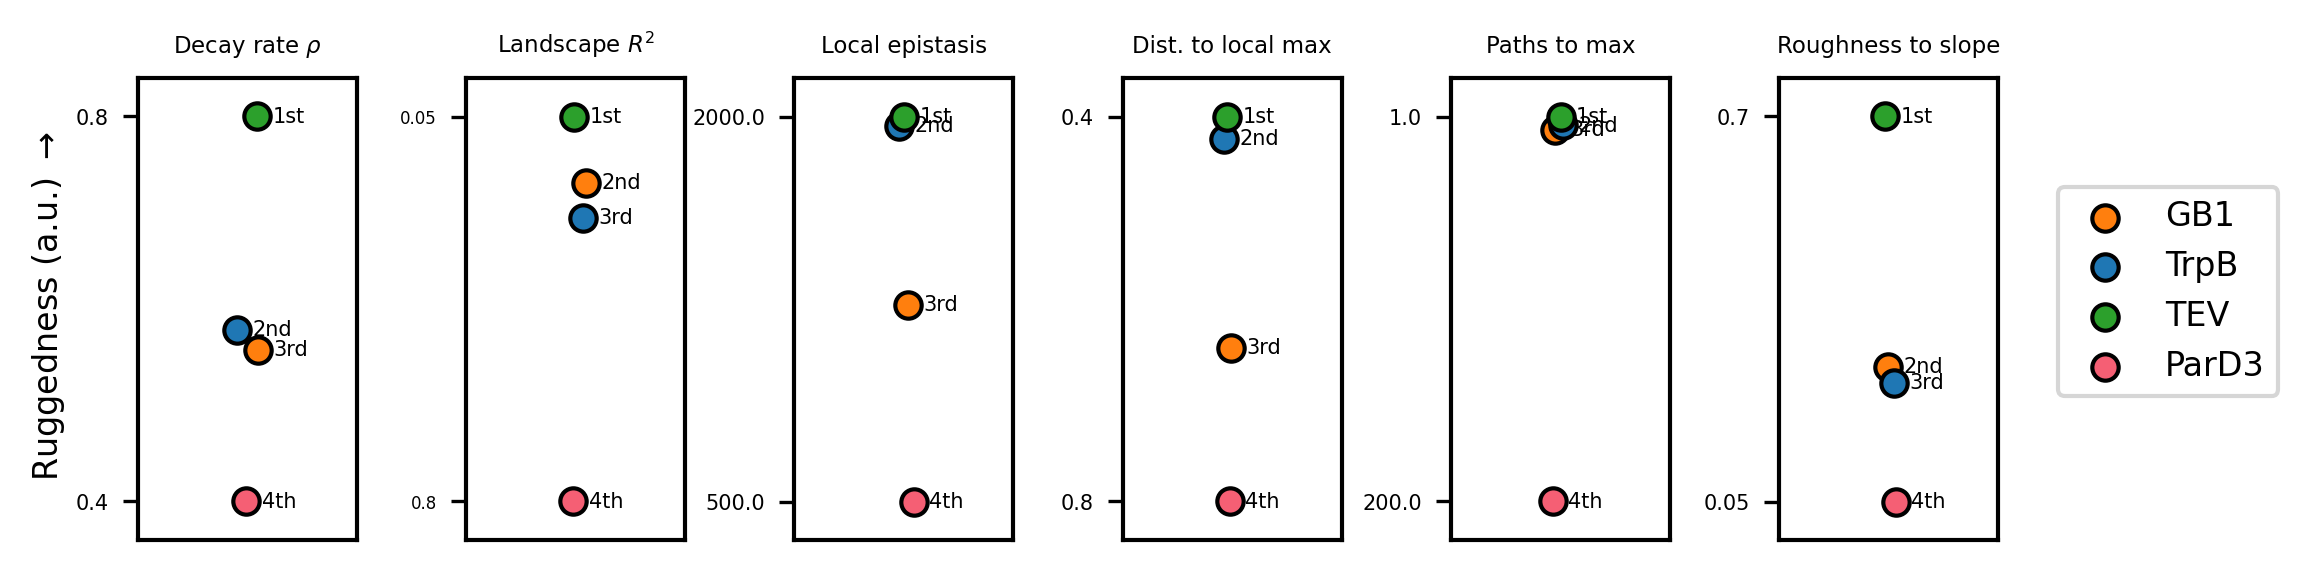

In [22]:
colours = [c1, c2, c4, c3]
labels = ['GB1', 'TrpB', 'TEV', 'ParD3']
rank_labels = ["1st", "2nd", "3rd", "4th"]
reversed_axes = {1, 3, 4}  # these get lowest->"1st"
titles = [r'Decay rate $\rho$', r'Landscape $R^2$', 'Local epistasis', 'Dist. to local max', 'Paths to max', 'Roughness to slope']

fig, axes = plt.subplots(1, 6, figsize=(8, 2), dpi=300)

for i, ax in enumerate(axes):

    y_positions = arr[i]                 # y-values for this metric (length 4)
    x_positions = np.full(4, 0.5)        # 4 points on x=0.5
    
    # Choose ranking order per axis
    order = np.argsort(y_positions) if i in reversed_axes else np.argsort(-y_positions)
    # Map each point j -> its rank index (0..3)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(y_positions))

    for j in range(4):
        jitter = np.random.uniform(-0.05, 0.05)
        x = x_positions[j] + jitter
        y = y_positions[j]

        ax.scatter(x, y,
                   color=colours[j], s=40, edgecolors='black', zorder=3,
                   label=labels[j] if i == 0 else None)
        # Rank label
        ax.text(x + 0.07, y, rank_labels[ranks[j]],
                fontsize=5, va='center', ha='left', zorder=4)

    # Outline
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Axes ticks
    ax.set_xticks([])
    ax.set_yticks([arr[i].min(), arr[i].max()])
    ax.set_yticklabels([r_sigfig(arr[i].min()), r_sigfig(arr[i].max())], fontsize=5)
    ax.set_xlim(0, 1)
    ax.margins(y=0.1)

    ax.set_title(titles[i], fontsize=titlesize-4.5)

# Legend
axes[0].legend(fontsize=legendsize, loc='upper left', bbox_to_anchor=(8.7, 0.8))
axes[1].set_yticklabels([r_sigfig(arr[1].min()), r_sigfig(arr[1].max())], fontsize=4)

# Invert y-axis where needed
for idx in [1, 3, 4]:
    axes[idx].invert_yaxis()

# Adjust spacing
plt.subplots_adjust(wspace=0.5)

# Global label
fig.text(0.08, 0.5, r'Ruggedness (a.u.) $\rightarrow$', fontsize=8, va='center', rotation=90)

plt.savefig('figures/empirical_ruggedness_metric_comparison.pdf', dpi=dpi)

In [23]:
with open('plot_data/fourier_spectra_empirical.pkl', 'rb') as f:
    spectra = pickle.load(f)

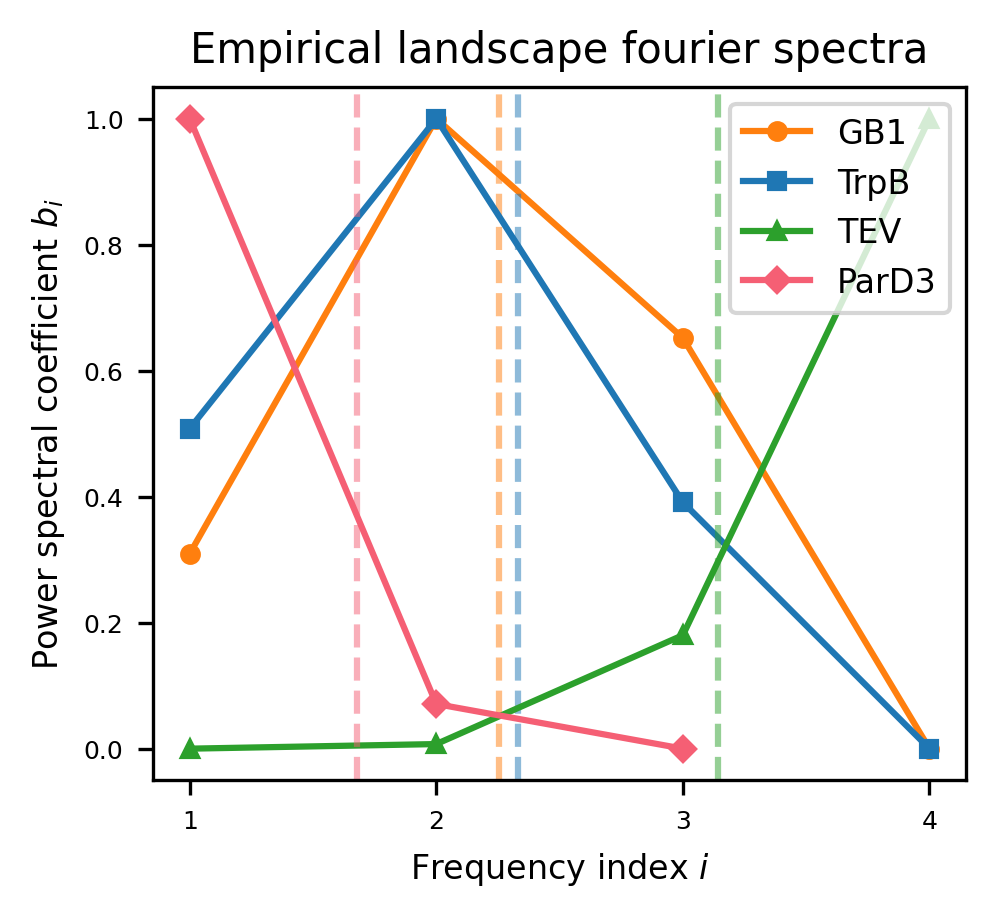

In [24]:
colours = [c1,c2,c4,c3]
labels = ['GB1', 'TrpB', 'TEV','ParD3']
markers = ['o','s','^','D']

plt.figure(figsize=(3.5,3), dpi=300)
A=20
N=4

for n,i in enumerate(spectra):
    i = i[1:]
    i_norm = (i - i.min()) / (i.max() - i.min())
    K = (decay_rate_measurements[n]*N)-1
    plt.plot(list(range(1,len(i_norm)+1)), i_norm, label=labels[n], c=colours[n], marker=markers[n],markersize=4)
    plt.axvline(x=(K + 1)*(A-1)/A, c=colours[n], linestyle='--', alpha=0.5)

plt.legend(fontsize=legendsize, loc='upper right')
plt.title('Empirical landscape fourier spectra', fontsize=titlesize)
plt.xlabel(r'Frequency index $i$', fontsize=labelsize)
plt.ylabel(r'Power spectral coefficient $b_i$', fontsize=labelsize)
plt.xticks(([1,2,3,4]))
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.savefig('figures/empirical_fourier_spectra.pdf', dpi=dpi)

In [25]:
with open('plot_data/subsampling_empirical_estimates.pkl', 'rb') as f:
    num_samples_totest, results_means, results_stds, data_names = pickle.load(f)

2025-09-19 11:22:18.340919: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


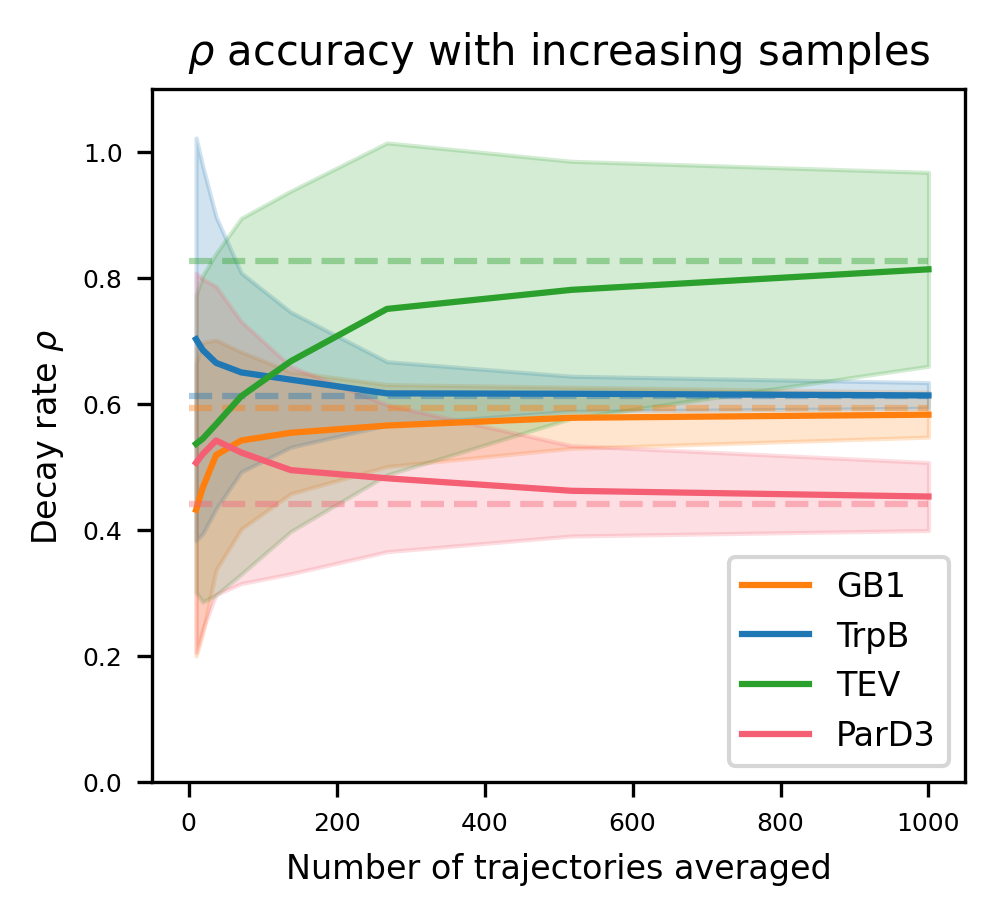

In [26]:
plt.figure(figsize=(3.5,3), dpi=300)
#plt.hlines(y=0, xmin=0, xmax=1000, linestyles='solid',color='grey', linestyle='--', label=r'Baseline')
for i in range(len(data_names)):
    plt.plot(num_samples_totest, results_means[i], label=data_names[i], c=colours[i])
    #plt.xscale('log')
    plt.fill_between(num_samples_totest, results_means[i] - results_stds[i], results_means[i] + results_stds[i], alpha=0.2, color=colours[i])
    plt.hlines(y=decay_rate_measurements[i], xmin=0, xmax=1000, color=colours[i], linestyle='--',alpha=0.4)
plt.xlabel('Number of trajectories averaged', fontsize=labelsize)
plt.ylabel(r'Decay rate $\rho$', fontsize=labelsize)
plt.title(r'$\rho$ accuracy with increasing samples', fontsize=titlesize)
plt.legend(fontsize = legendsize)
plt.ylim(0,1.1)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.savefig('figures/accuracy_over_sampling.pdf', dpi=dpi)

# Section 3 - Optimising directed evolution

### Optimal DE strategies from sweep

In [27]:
with open('plot_data/optimal_DE_strategies.pkl', 'rb') as f:
    decay_rates, optimal_splits, optimal_base_chances = pickle.load(f)

In [28]:
with open('plot_data/strategy_prediction_accuracy.pkl', 'rb') as f:
    actual_k_over_ns, bc_means, bc_stds, sp_means, sp_stds = pickle.load(f)

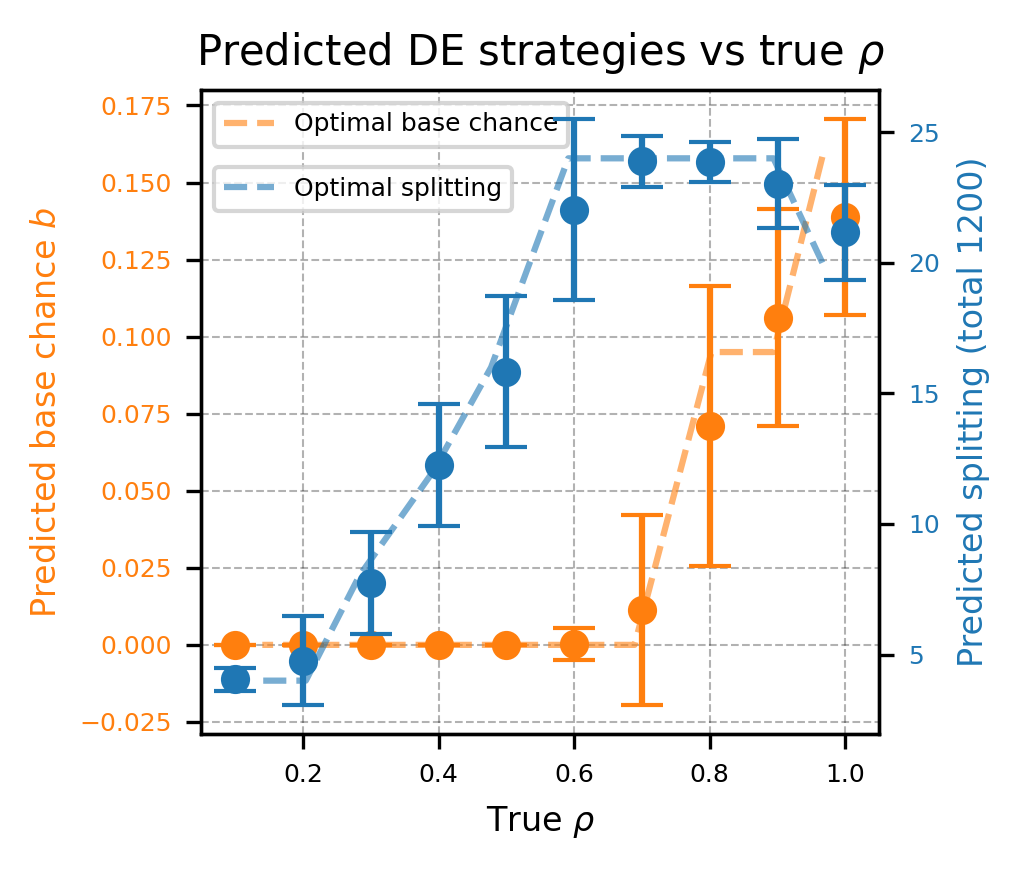

In [29]:
fig, ax1 = plt.subplots(figsize=(3.5,3), dpi=300)

k_over_ns = np.unique(np.round(actual_k_over_ns,1))

color = c1
ax1.set_xlabel(r'True $\rho$', fontsize=8)
ax1.set_ylabel(r'Predicted base chance $b$', color=color, fontsize=8)
ax1.errorbar(k_over_ns, bc_means, yerr=bc_stds, fmt='o', capsize=5, color=c1)
ax1.plot(decay_rates, optimal_base_chances, color=color, linestyle='--', alpha=0.6, label='Optimal base chance')
ax1.tick_params(axis='y', labelcolor=color, labelsize=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.3)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = c2
ax2.set_ylabel('Predicted splitting (total 1200)', color=color, fontsize=8) 
ax2.errorbar(k_over_ns, sp_means, yerr=sp_stds, fmt='o', capsize=5, color=c2)
ax2.plot(decay_rates, optimal_splits, color=color, linestyle='--', alpha=0.6, label='Optimal splitting')
ax2.tick_params(axis='y', labelcolor=color, labelsize=6)

ax1.set_title(r'Predicted DE strategies vs true $\rho$', fontsize=10)

# Adjust legend positions
ax1.legend(fontsize=legendsize-2, loc='upper left', bbox_to_anchor=(0.0, 1.0))
ax2.legend(fontsize=legendsize-2, loc='upper left', bbox_to_anchor=(0.0, 0.9))  # Move slightly below ax1's legend

plt.xlim(0.05, 1.05)
fig.tight_layout()
plt.savefig('figures/strategy_prediction.pdf', dpi=dpi)

### Directed evolution on smooth NK

In [4]:
with open('plot_data/NK_DE.pkl', 'rb') as f:
    DE_data = pickle.load(f)

with open('plot_data/NK_strategy_spaces.pkl', 'rb') as f:
    smooth_strategies, rugged_strategies = pickle.load(f)

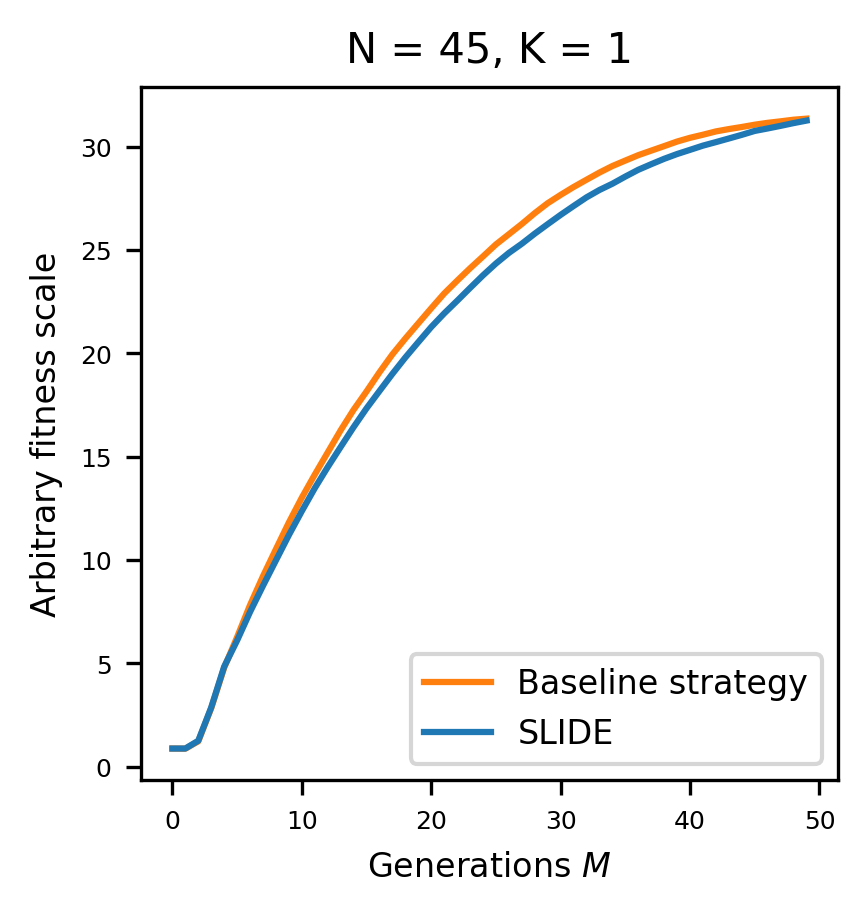

In [5]:
plt.figure(figsize=(3,3), dpi=300)
plt.plot(DE_data[0], label = 'Baseline strategy', color=c1)
plt.plot(DE_data[2], label = 'SLIDE', color=c2)
plt.ylabel('Arbitrary fitness scale', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title('N = 45, K = 1',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
plt.savefig('figures/N45K1_DE_fitness.pdf', dpi=dpi)

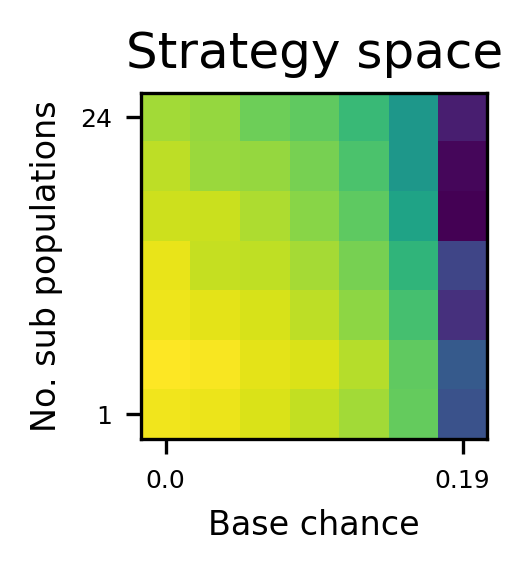

In [32]:
plt.figure(figsize = (1.5,1.5), dpi=300)
plt.imshow(smooth_strategies.mean(axis=1).reshape(7,7))
plt.xticks([0,6], labels = [0.0,0.19])
plt.yticks([0,6], labels = [24,1])
plt.ylabel('No. sub populations', fontsize=8)
plt.xlabel('Base chance', fontsize=8)
plt.title('Strategy space')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.savefig('figures/N45K1_DE_strategy_space.pdf', dpi=dpi)

### Directed evolution on rough NK

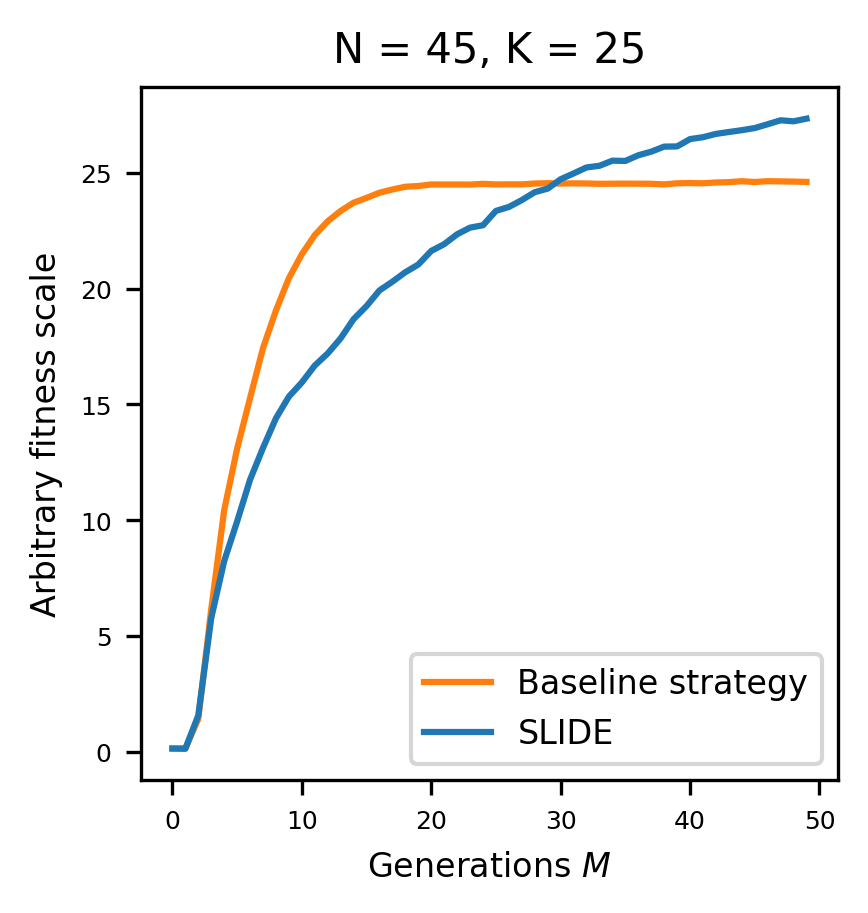

In [33]:
plt.figure(figsize=(3,3), dpi=300)
plt.plot(DE_data[1], label = 'Baseline strategy', color=c1)
plt.plot(DE_data[3], label = 'SLIDE', color=c2)
plt.ylabel('Arbitrary fitness scale', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title('N = 45, K = 25',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
plt.savefig('figures/N45K25_DE_fitness.pdf', dpi=dpi)

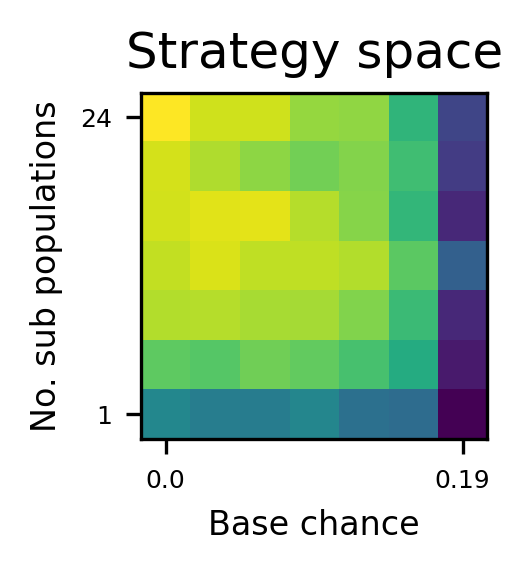

In [34]:
plt.figure(figsize = (1.5,1.5), dpi=300)
plt.imshow(rugged_strategies.mean(axis=1).reshape(7,7))
plt.xticks([0,6], labels = [0.0,0.19])
plt.yticks([0,6], labels = [24,1])
plt.ylabel('No. sub populations', fontsize=8)
plt.xlabel('Base chance', fontsize=8)
plt.title('Strategy space')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.savefig('figures/N45K25_DE_strategy_space.pdf', dpi=dpi)

### GB1 directed evolution

In [35]:
with open('plot_data/GB1_strategy_selection.pkl', 'rb') as f:
    x_vals, decay_mean, decay_rate, sweep, scipy_freq_matrix, run = pickle.load(f)

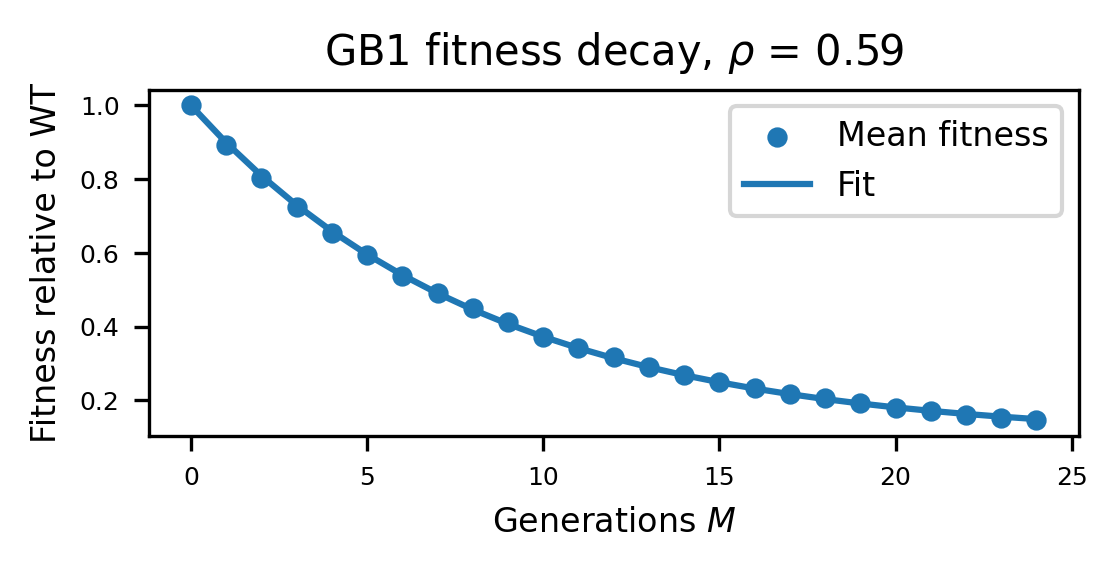

In [36]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.scatter(x_vals, decay_mean, color=c2, label='Mean fitness', s=15)
plt.plot(model_function(x_vals, *decay_rate), label='Fit', c=c2)
plt.ylabel('Fitness relative to WT', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title(f'GB1 fitness decay, $\\rho$ = {np.around(decay_rate[0]/2,2)}',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
#plt.ylim(0,1.1)
plt.savefig('figures/GB1_decay.pdf', dpi=dpi)

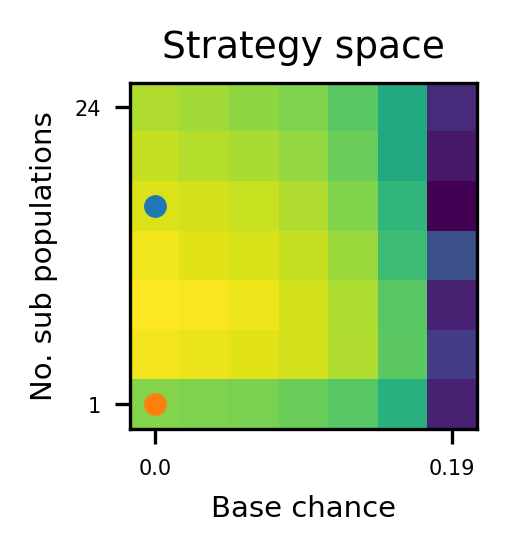

In [37]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
#plt.imshow(GB1_sweep.mean(axis=2))  # Assuming GB1_sweep is pre-defined
plt.imshow(sweep.mean(axis=(0,3)))

# Add scatter plot with dot size proportional to frequency
max_size = 100  # Adjust as needed
dot_sizes = (scipy_freq_matrix / scipy_freq_matrix.max()) * max_size

for i in range(7):  # Loop over rows
    for j in range(7):  # Loop over columns
        if scipy_freq_matrix[i, j] > 0:  # Only plot if frequency > 0
            plt.scatter(j, i, s=dot_sizes[i, j]*0.2, color=c2, alpha=1)

plt.scatter(0,6, s=20, color=c1, alpha=1)
#plt.scatter(0,1, s=30, color=c2, alpha=0.6, edgecolors='none')

# Formatting
plt.xticks([0, 6], labels=[0.0, 0.19])
plt.yticks([0, 6], labels=[24, 1])
plt.ylabel('No. sub populations', fontsize=labelsize - 1)
plt.xlabel('Base chance', fontsize=labelsize - 1)
plt.title('Strategy space', fontsize=titlesize - 1)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.savefig('figures/GB1_strategy_space.pdf', dpi=dpi)

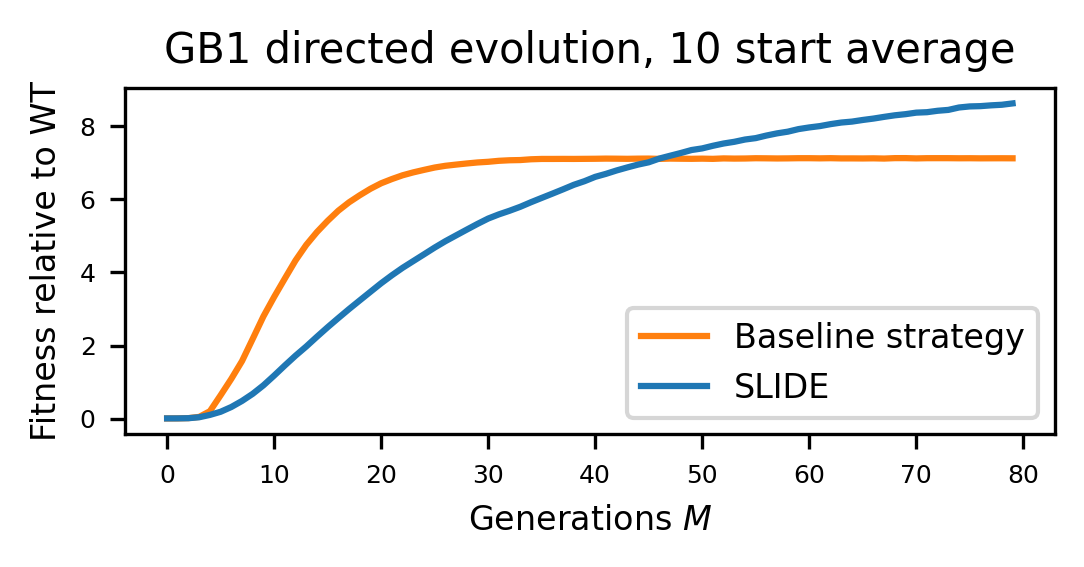

In [38]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.plot(np.array(run).mean(axis=0)[0], label = 'Baseline strategy', color=c1)
plt.plot(np.array(run).mean(axis=0)[1], label = 'SLIDE', color=c2)
plt.ylabel('Fitness relative to WT', fontsize=labelsize)
plt.xlabel(r'Generations $M$', fontsize=labelsize)
plt.title('GB1 directed evolution, 10 start average',fontsize=titlesize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize=8)
plt.savefig('figures/GB1_DE.pdf', dpi=dpi)

### TrpB Directed Evolution

In [39]:
with open('plot_data/TrpB_strategy_selection.pkl', 'rb') as f:
    x_vals, decay_mean, decay_rate, sweep, scipy_freq_matrix, run = pickle.load(f)

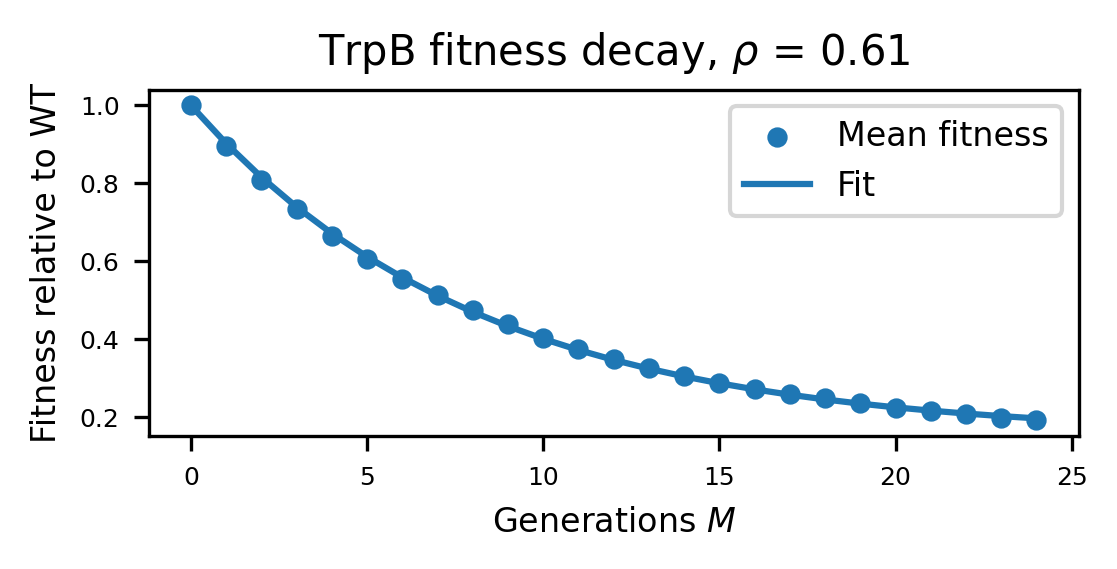

In [40]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.scatter(x_vals, decay_mean, color=c2, label='Mean fitness', s=15)
plt.plot(model_function(x_vals, *decay_rate), label='Fit', c=c2)
plt.ylabel('Fitness relative to WT', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title(f'TrpB fitness decay, $\\rho$ = {np.around(decay_rate[0]/2,2)}',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
#plt.ylim(0,1.1)

plt.savefig('figures/TrpB_decay.pdf', dpi=dpi)

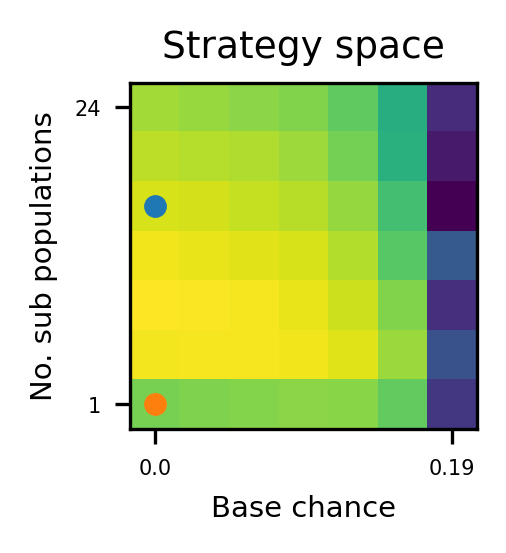

In [41]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
#plt.imshow(GB1_sweep.mean(axis=2))  # Assuming GB1_sweep is pre-defined
plt.imshow(sweep.mean(axis=(0,3)))

# Add scatter plot with dot size proportional to frequency
max_size = 100  # Adjust as needed
dot_sizes = (scipy_freq_matrix / scipy_freq_matrix.max()) * max_size

for i in range(7):  # Loop over rows
    for j in range(7):  # Loop over columns
        if scipy_freq_matrix[i, j] > 0:  # Only plot if frequency > 0
            plt.scatter(j, i, s=dot_sizes[i, j]*0.2, color=c2, alpha=1)

plt.scatter(0,6, s=20, color=c1, alpha=1)
#plt.scatter(0,1, s=30, color=c2, alpha=0.6, edgecolors='none')

# Formatting
plt.xticks([0, 6], labels=[0.0, 0.19])
plt.yticks([0, 6], labels=[24, 1])
plt.ylabel('No. sub populations', fontsize=labelsize - 1)
plt.xlabel('Base chance', fontsize=labelsize - 1)
plt.title('Strategy space', fontsize=titlesize - 1)
plt.tick_params(axis='both', which='major', labelsize=5)


plt.savefig('figures/TrpB_strategy_space.pdf', dpi=dpi)

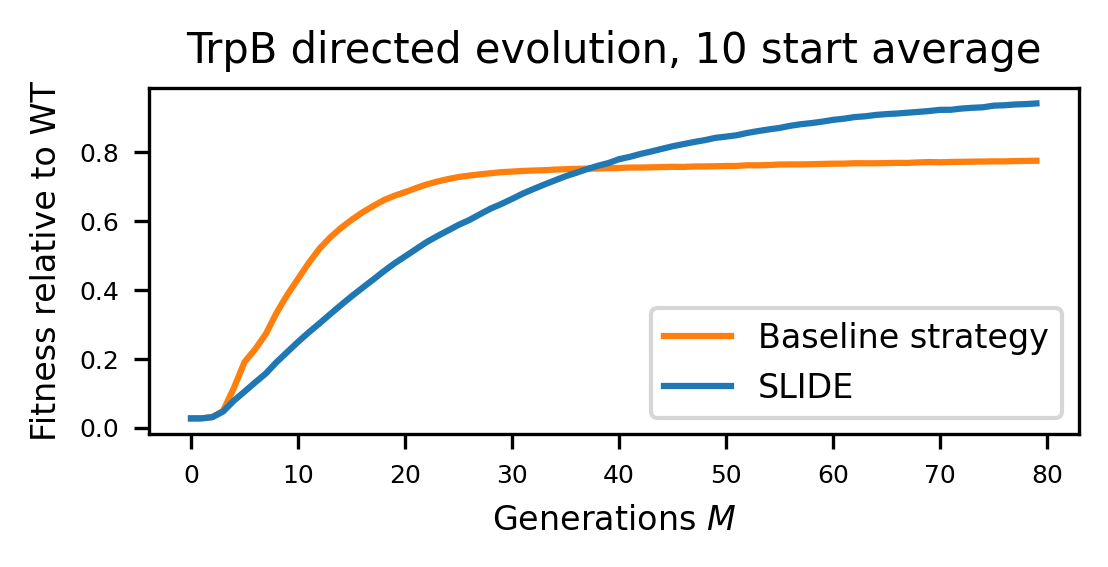

In [42]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.plot(np.array(run).mean(axis=0)[0], label = 'Baseline strategy', color=c1)
plt.plot(np.array(run).mean(axis=0)[1], label = 'SLIDE', color=c2)
plt.ylabel('Fitness relative to WT', fontsize=labelsize)
plt.xlabel(r'Generations $M$', fontsize=labelsize)
plt.title('TrpB directed evolution, 10 start average',fontsize=titlesize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize=8)

plt.savefig('figures/TrpB_DE.pdf', dpi=dpi)

### TEV Directed Evolution

In [43]:
with open('plot_data/TEV_strategy_selection.pkl', 'rb') as f:
    x_vals, decay_mean, decay_rate, sweep, scipy_freq_matrix, run = pickle.load(f)

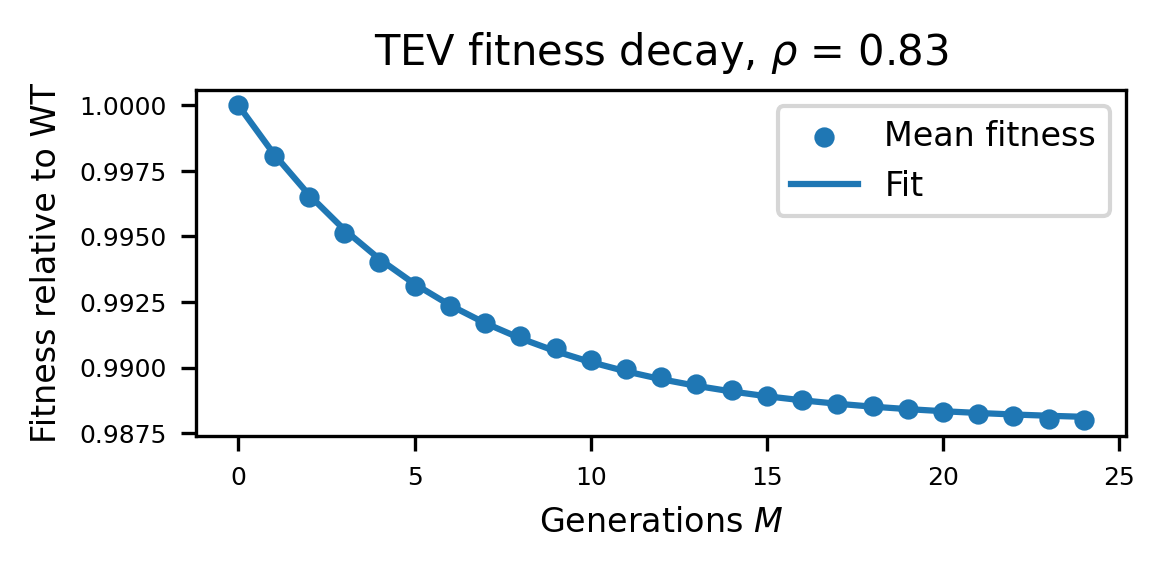

In [44]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.scatter(x_vals, decay_mean, color=c2, label='Mean fitness', s=15)
plt.plot(model_function(x_vals, *decay_rate), label='Fit', c=c2)
plt.ylabel('Fitness relative to WT', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title(f'TEV fitness decay, $\\rho$ = {np.around(decay_rate[0]/2,2)}',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
#plt.ylim(0,1.1)

plt.savefig('figures/TEV_decay.pdf', dpi=dpi)

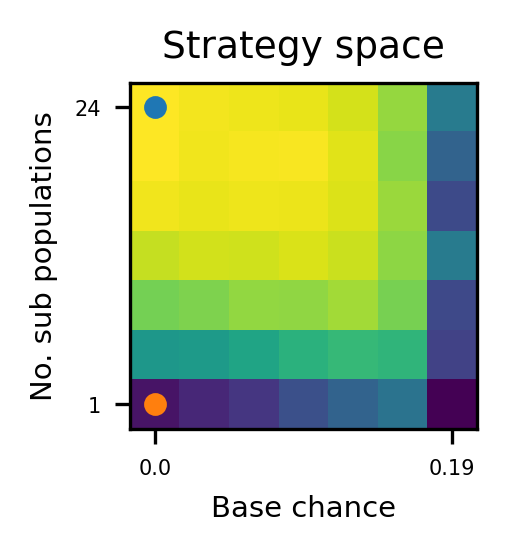

In [45]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
#plt.imshow(GB1_sweep.mean(axis=2))  # Assuming GB1_sweep is pre-defined
plt.imshow(sweep.mean(axis=(0,3)))

# Add scatter plot with dot size proportional to frequency
max_size = 100  # Adjust as needed
dot_sizes = (scipy_freq_matrix / scipy_freq_matrix.max()) * max_size

for i in range(7):  # Loop over rows
    for j in range(7):  # Loop over columns
        if scipy_freq_matrix[i, j] > 0:  # Only plot if frequency > 0
            plt.scatter(j, i, s=dot_sizes[i, j]*0.2, color=c2, alpha=1)

plt.scatter(0,6, s=20, color=c1, alpha=1)
#plt.scatter(0,1, s=30, color=c2, alpha=0.6, edgecolors='none')

# Formatting
plt.xticks([0, 6], labels=[0.0, 0.19])
plt.yticks([0, 6], labels=[24, 1])
plt.ylabel('No. sub populations', fontsize=labelsize - 1)
plt.xlabel('Base chance', fontsize=labelsize - 1)
plt.title('Strategy space', fontsize=titlesize - 1)
plt.tick_params(axis='both', which='major', labelsize=5)


plt.savefig('figures/TEV_strategy_space.pdf', dpi=dpi)

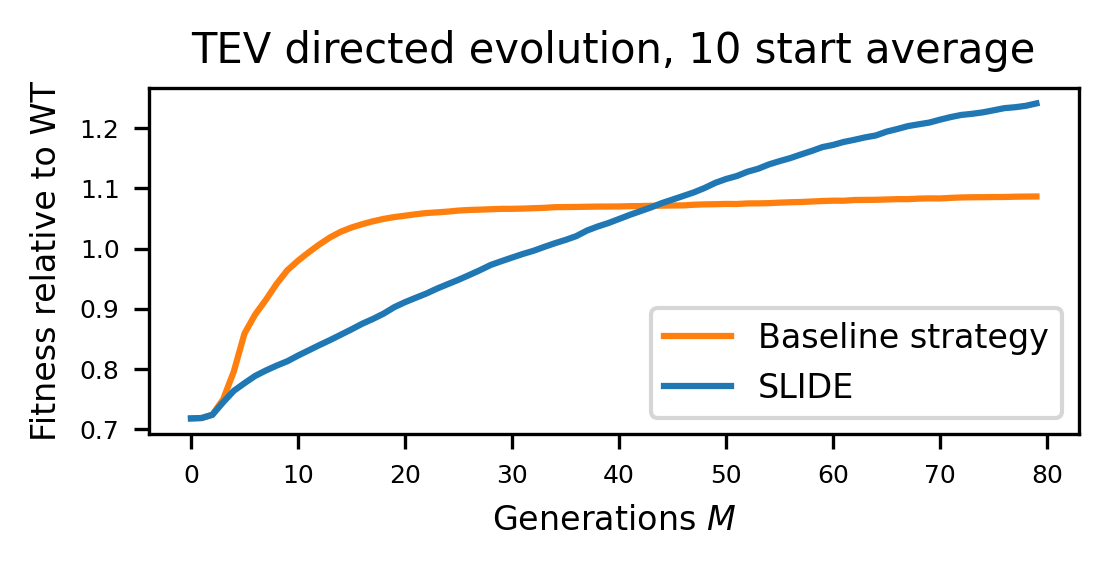

In [46]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.plot(np.array(run).mean(axis=0)[0], label = 'Baseline strategy', color=c1)
plt.plot(np.array(run).mean(axis=0)[1], label = 'SLIDE', color=c2)
plt.ylabel('Fitness relative to WT', fontsize=labelsize)
plt.xlabel(r'Generations $M$', fontsize=labelsize)
plt.title('TEV directed evolution, 10 start average',fontsize=titlesize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize=8)

plt.savefig('figures/TEV_DE.pdf', dpi=dpi)

## ParD3

In [47]:
with open('plot_data/ParD3_strategy_selection.pkl', 'rb') as f:
    x_vals, decay_mean, decay_rate, sweep, scipy_freq_matrix, run = pickle.load(f)

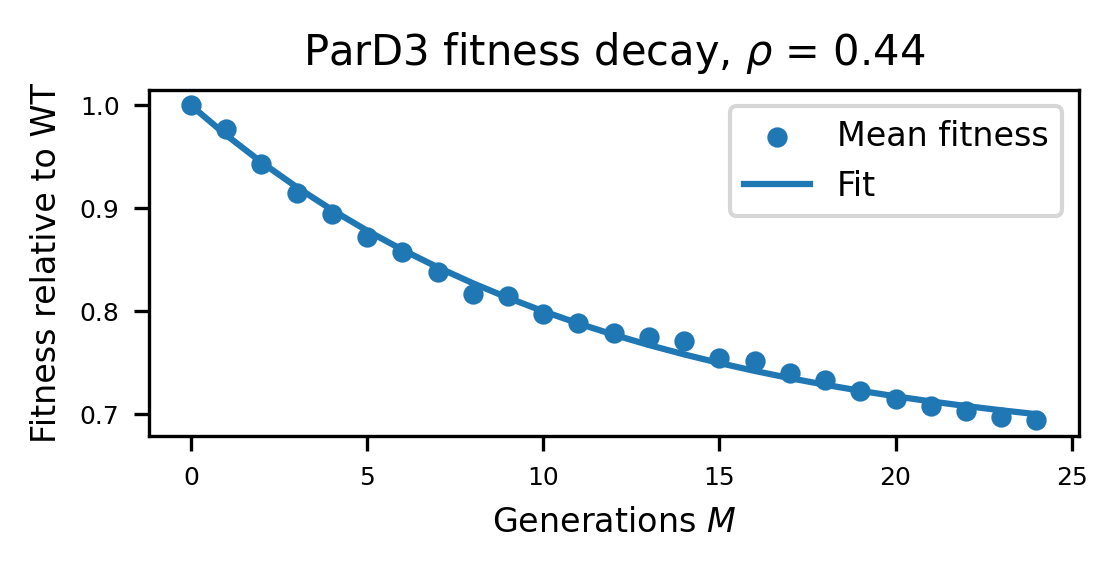

In [48]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.scatter(x_vals, decay_mean, color=c2, label='Mean fitness', s=15)
plt.plot(model_function(x_vals, *decay_rate), label='Fit', c=c2)
plt.ylabel('Fitness relative to WT', fontsize=8)
plt.xlabel(r'Generations $M$', fontsize=8)
plt.title(f'ParD3 fitness decay, $\\rho$ = {np.around(decay_rate[0]/2,2)}',fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.legend(fontsize=8)
#plt.ylim(0,1.1)

plt.savefig('figures/ParD3_decay.pdf', dpi=dpi)

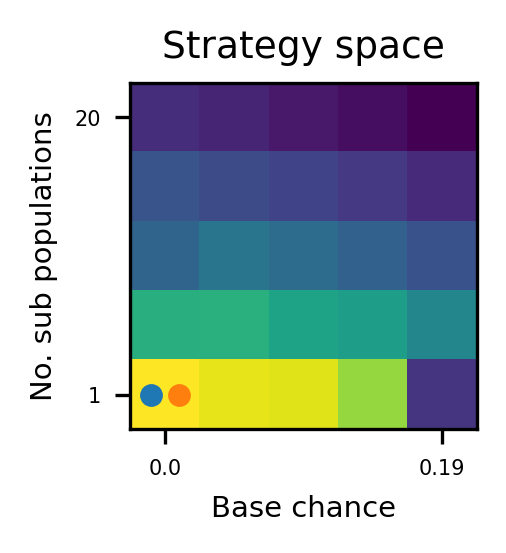

In [49]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
#plt.imshow(GB1_sweep.mean(axis=2))  # Assuming GB1_sweep is pre-defined
plt.imshow(sweep.mean(axis=(0,3)))

# Add scatter plot with dot size proportional to frequency
max_size = 100  # Adjust as needed
dot_sizes = (scipy_freq_matrix / scipy_freq_matrix.max()) * max_size

for i in range(5):  # Loop over rows
    for j in range(5):  # Loop over columns
        if scipy_freq_matrix[i, j] > 0:  # Only plot if frequency > 0
            plt.scatter(j-0.2, i, s=dot_sizes[i, j]*0.2, color=c2, alpha=1)

plt.scatter(0+0.2,4, s=20, color=c1, alpha=1)
#plt.scatter(0,1, s=30, color=c2, alpha=0.6, edgecolors='none')

# Formatting
plt.xticks([0, 4], labels=[0.0, 0.19])
plt.yticks([0, 4], labels=[20, 1])
plt.ylabel('No. sub populations', fontsize=labelsize - 1)
plt.xlabel('Base chance', fontsize=labelsize - 1)
plt.title('Strategy space', fontsize=titlesize - 1)
plt.tick_params(axis='both', which='major', labelsize=5)


plt.savefig('figures/ParD3_strategy_space.pdf', dpi=dpi)

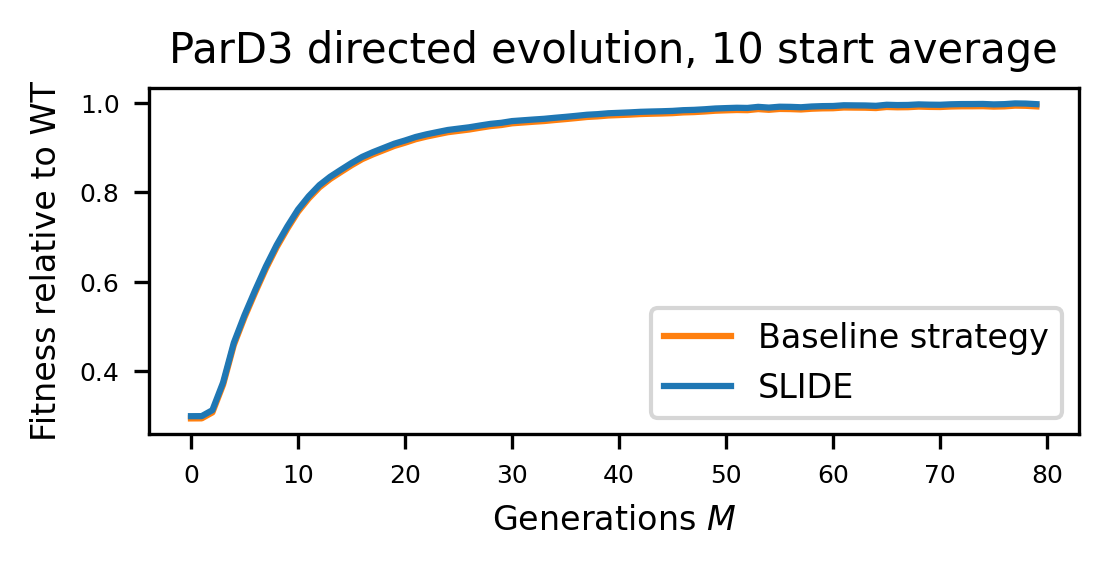

In [50]:
plt.figure(figsize=(4,1.5), dpi=300)
plt.plot(np.array(run).mean(axis=0)[0]-0.005, label = 'Baseline strategy', color=c1)
plt.plot(np.array(run).mean(axis=0)[1], label = 'SLIDE', color=c2)
plt.ylabel('Fitness relative to WT', fontsize=labelsize)
plt.xlabel(r'Generations $M$', fontsize=labelsize)
plt.title('ParD3 directed evolution, 10 start average',fontsize=titlesize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize=8)

plt.savefig('figures/ParD3_DE.pdf', dpi=dpi)

### Fourier Methods Figure

In [51]:
with open('plot_data/fourier_analysis.pkl', 'rb') as f:
    nk_data = pickle.load(f)
    
def get_exp_matrix(
    N: int,
    A: int,
    mutations: np.array,
    is_squared: bool = True,
    fix_b0: bool = False,
) -> np.array:
    eigrange = range(N+1) if fix_b0 == False else range(1, N+1)
    eigenvalues = [A*i for i in eigrange]
    factor = 2 if is_squared is True else 1
    if fix_b0:
        return np.array([[np.exp(-mut/(N*(A-1))*l*factor)-1 for l in eigenvalues] for mut in mutations[1:]])
    else:
        return np.array([[np.exp(-mut/(N*(A-1))*l*factor) for l in eigenvalues] for mut in mutations])


## Measure decay rate function.
def get_fourier_coeffs(
    mean_fitness: np.array,
    mutations: np.array,
    N: int,
    A: int,
    is_squared: bool = False,
    fix_b0: bool = False,
    method: str = "nnls",
    alpha: str = 0.1,
) -> tuple[np.array, np.array]:
    """
    Inputs:
    mean_fitness: vector with mean fitness values
    mutations: vector with number of mutations, starting with 0
    N: length of gene
    A: number of alleles (e.g., 20 if amino acids)
    is_squared: flag to set true if mean fitness squared is provided instead.
    method: pick on of ls, ls_constrained, nnls. Results may vary. Latter to enforce positiveness of the coeffs, although positiveness is only true for the squared estimate.
    Outputs:
    (fourier_coeffs, exponentials): tuple[np.array, np.array]
    fourier_coeffs: Vector of length N+1 with Fourier coeffs from low to high frequency, with the first element corresponding to the constant.
    exponentials: len(mutations)xN+1 matrix to extract fit via exponentials*weights
    """
    exponentials = get_exp_matrix(N=N, A=A, mutations=mutations, is_squared=is_squared, fix_b0=fix_b0)
    if fix_b0:
        mean_fitness_0 = mean_fitness[0]
        mean_fitness = mean_fitness[1:] - mean_fitness_0
    if method == "ls":
        fourier_coeffs, residuals, rank, s = np.linalg.lstsq(exponentials, mean_fitness, rcond=None)
    elif method == "ls_constrained":
        res = scipy.optimize.lsq_linear(exponentials, mean_fitness, bounds=(0, np.inf))
        fourier_coeffs = res.x
    elif method == "nnls":
        fourier_coeffs, rnorm = scipy.optimize.nnls(exponentials, mean_fitness)
    elif method == "nnls_reg":
        if alpha < 0:
            raise ValueError("alpha must be >= 0")
        m, p = exponentials.shape
        A_aug = np.vstack([exponentials, np.sqrt(alpha) * np.eye(p)])
        b_aug = np.concatenate([mean_fitness, np.zeros(p)])
        fourier_coeffs, _ = scipy.optimize.nnls(A_aug, b_aug)
    else:
        raise ValueError("Method unavailable.")
    if fix_b0:
        b0 = mean_fitness_0 - np.sum(np.abs(fourier_coeffs))
        fourier_coeffs = np.concatenate((np.array([b0]), fourier_coeffs))
        exponentials = get_exp_matrix(N=N, A=A, mutations=mutations, is_squared=is_squared, fix_b0=False)
    return (fourier_coeffs, exponentials)

def model_function(x,*params):

    """
    This is the what we are fitting to (sum of exponentials).
    It assumes a decay rate of 0.5 mutations per step.

    x = steps
    params = the output of the fitting function (get_single_decay_rate).
    """

    mut = 0.5
    num_params = 1
    constant = params[-1]
    params = params[:-1]
    mut_curves = np.exp(-1.0*mut*x[:,None]*np.array(params)[None,:])
    weights = np.linspace(0.1, 0.9, num_params)
    weights = np.ones(num_params)
    weights = weights / weights.sum()
    sum_curves = np.sum(mut_curves * weights[None,:], axis = 1)
    return sum_curves * (1 - constant) + constant

## Measure decay rate function.

def get_single_decay_rate(decay_data, mut = 0.5, num_steps = 25):

    num_params = 1
    decay_data = decay_data/decay_data[0]

    if isinstance(mut, (int, float, complex)) or jnp.ndim(mut) == 0:
        steps = np.linspace(0,num_steps-1,num_steps)
    else:
        steps = mut

    if mut is None:
        mut = np.arange(len(decay_data))  # Default steps
    
    init_guess = np.linspace(0.1, 0.9, num_params)
    init_guess = np.concat([init_guess,[0.0]])
    lbounds = [0.0]*num_params + [-0.4]
    ubounds = [2.0]*num_params + [0.4]

    # From chatgpt
    #asymptote_guess = decay_data[-3:].mean() / decay_data[0]
    #lower_bound = max(0.0, asymptote_guess - 0.2)
    #upper_bound = min(1.1, asymptote_guess + 0.2)

    #init_guess = np.concatenate([np.linspace(0.1, 0.9, num_params), [asymptote_guess]])
    #lbounds = [0.0]*num_params + [lower_bound]
    #ubounds = [2.0]*num_params + [upper_bound]

    params, _ = curve_fit(model_function, steps, decay_data,p0=init_guess, maxfev= 9000, ftol = 1e-4, xtol = 1e-5, bounds = (lbounds, ubounds))

    mean_params = np.mean(params[:-1])
    fitted_constant = params[-1]  # The second returned parameter

    return mean_params, fitted_constant  # Return full params for plotting

def get_single_decay_rate_NEW(decay_data, mut = 0.1, num_steps = 25):

    num_params = 2
    decay_data = decay_data/decay_data[0]
    def model_function(x,*params):
        mut_curves = np.exp(-1.0*mut*x[:,None]*np.array(params)[None,:])
        weights = np.linspace(0.1, 0.9, num_params)
        weights = np.ones(num_params)
        weights = weights / weights.sum()
        sum_curves = np.sum(mut_curves * weights[None,:], axis = 1)
        return sum_curves
    
    steps = np.linspace(0,num_steps-1,num_steps)

    init_guess = np.linspace(0.1, 0.9, num_params)
    params, _ = curve_fit(model_function, steps, decay_data,p0=init_guess, maxfev= 5000)

    mean_params = np.mean(params)
    return mean_params

In [52]:
N = nk_data['N_used']
K_vec = nk_data['Ks_used']
A = nk_data['A_used']
NK_landscapes = nk_data['nk_builts']
NK_spectra = []
NK_max = [(K+1)*(A-1)/A for K in K_vec]
for f in NK_landscapes:
    NK_spectra.append(get_landscape_spectrum(f, norm = True, remove_constant = False, on_gpu = True))
    
mut = 0.5
mutations = np.arange(start=0, stop=5.5, step=mut)
num_steps = len(mutations)
exponentials = get_exp_matrix(N=N, A=A, mutations=mutations, is_squared=True)
fitness_decay = []
fitness_decay_terms = []
fitted_decay = []
fitted_rho = []
fitted_rho_NEW = []
for i, K in enumerate(K_vec):
    fitness_decay.append(np.dot(exponentials, NK_spectra[i]))
    fitness_decay[i] = fitness_decay[i]# /fitness_decay[i][0]
    fitness_decay_terms_K = np.zeros(exponentials.shape)
    for j in range(exponentials.shape[1]):
        fitness_decay_terms_K[:, j] = exponentials[:, j] * NK_spectra[i][j]
    fitness_decay_terms.append(fitness_decay_terms_K)
    
    estim_data = get_single_decay_rate(fitness_decay[i], mut = mut, num_steps = num_steps)
    fitted_decay.append(np.array([np.exp(-mutations*(estim_data[0]))*(1 - estim_data[-1])]))
    fitted_rho.append(estim_data[0])
    fitted_rho_NEW.append(get_single_decay_rate_NEW(fitness_decay[i], mut = mut, num_steps = num_steps))

findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Open Sans' not found.


findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: 

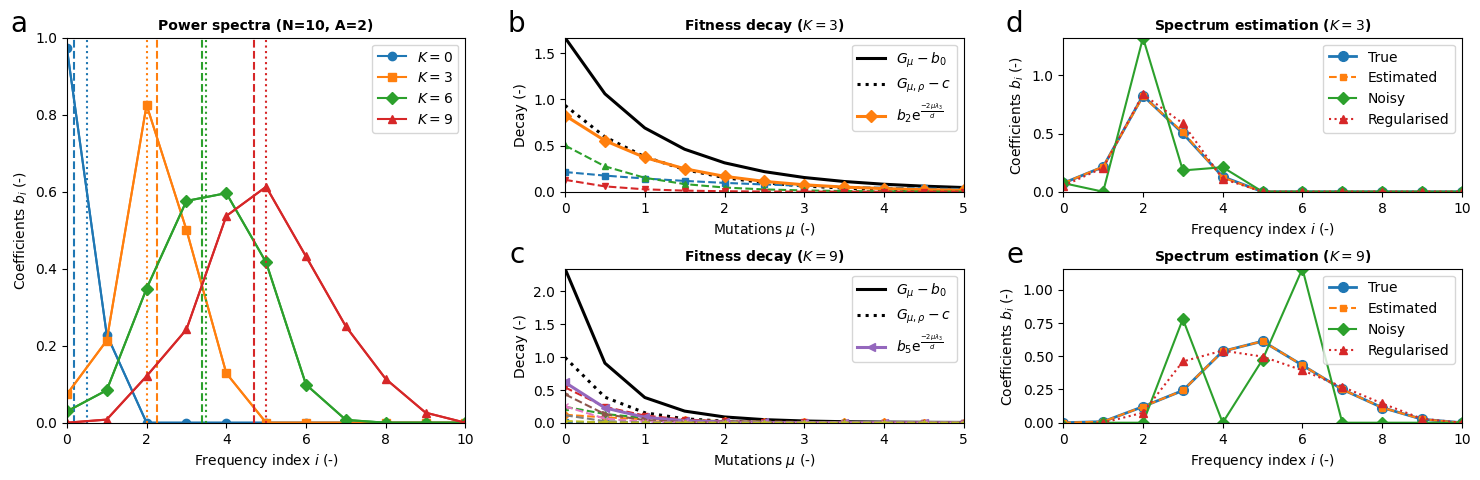

In [53]:
# Set globally
rcParams['font.family'] = 'Open Sans'

N = nk_data['N_used']
K_vec = nk_data['Ks_used']
A = nk_data['A_used']
NK_landscapes = nk_data['nk_builts']
NK_spectra = []
NK_max = [(K+1)*(A-1)/A for K in K_vec]
for f in NK_landscapes:
    NK_spectra.append(get_landscape_spectrum(f, norm = True, remove_constant = False, on_gpu = True))
    
mut = 0.5
mutations = np.arange(start=0, stop=5.5, step=mut)
num_steps = len(mutations)
exponentials = get_exp_matrix(N=N, A=A, mutations=mutations, is_squared=True)
fitness_decay = []
fitness_decay_terms = []
fitted_decay = []
fitted_rho = []
for i, K in enumerate(K_vec):
    fitness_decay.append(np.dot(exponentials, NK_spectra[i]))
    tmp = 1 # fitness_decay[i][0]
    fitness_decay[i] = fitness_decay[i] /tmp
    NK_spectra[i] = NK_spectra[i] / tmp
    fitness_decay_terms_K = np.zeros(exponentials.shape)
    for j in range(exponentials.shape[1]):
        fitness_decay_terms_K[:, j] = exponentials[:, j] * NK_spectra[i][j]
    fitness_decay_terms.append(fitness_decay_terms_K)
    
    estim_data = get_single_decay_rate(fitness_decay[i], mut = mut, num_steps = num_steps)
    # fitted_decay.append(np.array([np.exp(-mutations*(estim_data[0]))*(1 - estim_data[-1]) + estim_data[-1]]))
    fitted_decay.append(np.array([np.exp(-mutations*(estim_data[0]))*(1 - estim_data[-1])]))
    fitted_rho.append(estim_data[0])

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'x', '+', '*']
import itertools

linestyles = ['-', '--', '-.', ':']

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(2, 3, figure=fig)

axx = fig.add_subplot(gs[:, 0])
for i, nk in enumerate(K_vec):
    line, = axx.plot(
        range(N + 1), NK_spectra[i],
        label=f"$K={nk}$",
        marker=markers[i],
        markersize=6,
        linewidth=1.5
    )
    color = line.get_color()
    axx.axvline(NK_max[i], color=color, linestyle=':')
    axx.axvline(fitted_rho[i]*N*(A-1)/2/A, color=color, linestyle='--')
    # axx.axvline(fitted_rho_NEW[i]*N*(A-1)/2/A, color=color, linestyle='-.')
    line, = axx.plot(
        range(N + 1), NK_spectra[i],
        color=color,
        markersize=6,
        linewidth=1.5
    )
axx.legend()
axx.set_xlim([0, N])
axx.set_ylim([0, 1])
axx.set_xlabel("Frequency index $i$ (-)")
axx.set_ylabel(f"Coefficients $b_i$ (-)")
axx.set_title(f"Power spectra (N={N}, A={A})", fontsize=10, fontweight='bold')
axx.text(
    -0.1, 1, "a",            # x, y in axes fraction
    transform=axx.transAxes,
    fontsize=20,
    va='bottom', ha='right'
)

# middle plot
for axi, (sel, ii) in enumerate(zip([1,3],[2,5])):
    axx = axx = fig.add_subplot(gs[axi, 1])
    
    axx.plot(
        mutations, fitness_decay[sel]-fitness_decay_terms[sel][0, 0],
        label=f"$G_{{\\mu}}-b_0$", color='k', linestyle='-', markersize=6, linewidth=2.2,
    )
    axx.plot(
        mutations, fitted_decay[sel][0,:],
        label=f"$G_{{\\mu,\\rho}}-c$", color='black', linestyle=':', markersize=6, linewidth=2.2,
    )
    for j, (ls, mk) in zip(range(exponentials.shape[1]), itertools.product(linestyles, markers)):
        if j>0 and NK_spectra[sel][j]>1e-4:
            if j == ii:
                axx.plot(
                    mutations,
                    fitness_decay_terms[sel][:, j], # + fitness_decay[sel] - fitness_decay_terms[sel][0, j],
                    label=f"$b_{{{j}}}\\mathrm{{e}}^{{\\frac{{-2\\mu\\lambda_{i}}}{{d}}}}$", 
                    linestyle='-', 
                    marker=mk, markersize=6, linewidth=2.2,
                )
            else:
                axx.plot(
                    mutations,
                    fitness_decay_terms[sel][:, j], # + fitness_decay[sel] - fitness_decay_terms[sel][0, j],
                    #label=f"$b_{{{j}}}\\mathrm{{e}}^{{\\frac{{-2\\mu\\lambda_{i}}}{{d}}}}$", 
                    linestyle='--', 
                    marker=mk, markersize=4, linewidth=1.5,
                )
    axx.legend(ncol=1)
    axx.set_title(f"Fitness decay ($K={K_vec[sel]}$)", fontsize=10, fontweight='bold')
    axx.set_xlabel(f"Mutations $\\mu$ (-)", )
    axx.set_ylabel(f"Decay (-)" )
    axx.set_xlim([0,mutations.max()])
    axx.set_ylim([0,(fitness_decay[sel]-fitness_decay_terms[sel][0, 0]).max()])
    
    letters = ["b", "c"]
    axx.text(
        -0.1, 1, letters[axi],
        transform=axx.transAxes,
        fontsize=20,
        va='bottom', ha='right'
    )
    
# right plot
for i, sel in enumerate([1,3]):
    decay = fitness_decay[sel]
    np.random.seed(2122)
    dnoise = 0.05
    noise = np.random.uniform(low=-dnoise,high=dnoise,size=fitness_decay[sel].shape)
    decay_noisy = fitness_decay[sel] + noise

    spectrum, _ = get_fourier_coeffs(mean_fitness=decay, mutations=mutations, N=N, A=A, is_squared=True, method="ls_constrained", fix_b0=True)
    spectrum_noisy, _ = get_fourier_coeffs(mean_fitness=decay_noisy, mutations=mutations, N=N, A=A, is_squared=True, method="nnls", fix_b0=True)
    spectrum_reg, _ = get_fourier_coeffs(mean_fitness=decay_noisy, mutations=mutations, N=N, A=A, is_squared=True, method="nnls_reg",alpha=1e-3, fix_b0=True)

    axx = fig.add_subplot(gs[i, 2])
    axx.plot(range(N + 1), NK_spectra[sel], label=f"True", markersize=7, linewidth=2, marker=markers[0])
    axx.plot(range(N + 1), spectrum, label=f"Estimated", markersize=5, linewidth=1.5, marker=markers[1], linestyle="--")
    axx.plot(range(N + 1), spectrum_noisy, label=f"Noisy", markersize=6, linewidth=1.5, marker=markers[2], linestyle="-")
    axx.plot(range(N + 1), spectrum_reg, label=f"Regularised", markersize=6, linewidth=1.5, marker=markers[3], linestyle=":")
    axx.legend()
    axx.set_xlim([0, N])
    axx.set_ylim([0, max(1,spectrum_noisy.max())])
    axx.set_xlabel("Frequency index $i$ (-)")
    axx.set_ylabel(f"Coefficients $b_i$ (-)")
    axx.set_title(f"Spectrum estimation ($K={K_vec[sel]}$)", fontsize=10, fontweight='bold')
    
    letters = ["d", "e"]
    axx.text(
        -0.1, 1, letters[i],
        transform=axx.transAxes,
        fontsize=20,
        va='bottom', ha='right'
    )
    
fig.subplots_adjust(hspace=0.5, wspace=0.25)
plt.savefig('figures/NK_spectra.pdf', dpi=dpi)